In [ ]:
!pip install esm torch numpy umap-learn transformers wandb tqdm pandas ml-collections matplotlib

In [4]:
import sys
import os

# Ensure the working directory is set to the project root
os.chdir("/Users/johnmars/Desktop/Msc-Github/PLMs")

# Add `src/` directory to Python's module search path
src_path = os.path.abspath("src")
if src_path not in sys.path:
    sys.path.insert(0, src_path)

In [7]:
import torch
from src.configurations import create_config
from src.esm_model import ESM2, ESM2EncoderModel
from src.interpolations import linear_interpolation, sinusoidal_interpolation, arccos_interpolation, decode_interpolations
from src.visualization import plot_umap_2d, plot_umap_3d
from src.utils import generate_random_sequence, levenshtein_distance
import numpy as np
import pandas as pd

In [12]:
# --- Load the ESM-2 model and prepare sequences ---
# (We use the ESM2 class from esm_model.py which wraps model loading.)
esm_model = ESM2("esm2_t33_650M_UR50D")
batch_converter = esm_model.alphabet.get_batch_converter()

# Define your two protein sequences
sequences = [
    ("ADAM_2065", "GIWSSIKNLASKAWNSDIGQSLRNKAAGAINKFVADKIGVTPSQAASMTLDEIVDAMYYD"),
    ("DRAMP04678", "DSECLKEYGGDVGFGFCAPRIYPSFCVQRCRADKGALSGKCIWGQGSNVKCLCNFCRHEP")
]

# Prepare the batch using the batch_converter
batch_labels, batch_strs, batch_tokens = batch_converter(sequences)

# Run the model to get token embeddings (using layer 33)
with torch.no_grad():
    results = esm_model.model(batch_tokens, repr_layers=[33], return_contacts=True)
    token_embeddings = results["representations"][33]

# Extract embeddings for each sequence (ignoring the special token at index 0)
sequence_embedding_1 = token_embeddings[0, 1:len(sequences[0][1]) + 1]
sequence_embedding_2 = token_embeddings[1, 1:len(sequences[1][1]) + 1]

# Print out the embeddings and their shapes
print("Embedding for ADAM_2065:")
print(sequence_embedding_1)
print("Embedding for DRAMP04678:")
print(sequence_embedding_2)
print("Shape of embedding 1:", sequence_embedding_1.shape)
print("Shape of embedding 2:", sequence_embedding_2.shape)

# (Optional) Ensure both embeddings have the same length
assert sequence_embedding_1.shape[0] == sequence_embedding_2.shape[0], "Sequence lengths must match"


Embedding for ADAM_2065:
tensor([[ 3.2904e-01,  1.2956e-01, -1.4446e-02,  ...,  8.6708e-02,
          3.1902e-02, -4.6907e-02],
        [ 1.7477e-02,  6.2520e-02, -7.3867e-02,  ..., -2.9889e-02,
         -6.6240e-02,  1.0199e-01],
        [ 1.4133e-02, -3.1425e-04, -1.4699e-02,  ..., -3.6334e-02,
         -2.4032e-01,  4.6868e-02],
        ...,
        [ 1.6679e-01,  8.7199e-03, -8.4602e-02,  ..., -4.5252e-02,
         -4.2468e-02, -3.8133e-02],
        [ 1.6871e-01,  6.4987e-02, -1.2020e-01,  ..., -7.7319e-02,
         -1.5173e-01,  1.4546e-01],
        [ 8.5060e-02,  1.0324e-01,  5.2795e-02,  ..., -9.8980e-02,
         -3.5499e-02,  2.6400e-01]])
Embedding for DRAMP04678:
tensor([[ 0.1422,  0.0709, -0.1444,  ...,  0.0688,  0.2839, -0.0491],
        [ 0.1434,  0.0907, -0.0064,  ..., -0.1822, -0.0357, -0.0195],
        [ 0.1838,  0.0435, -0.0674,  ..., -0.1292,  0.0781, -0.0336],
        ...,
        [ 0.0160, -0.1732, -0.2885,  ..., -0.2444,  0.1643, -0.0984],
        [ 0.0444, -0.097

In [13]:
# --- Compute Interpolations ---
# Define lambda values (10 steps from 0 to 1)
lambdas = torch.linspace(0, 1, steps=10)

# Compute interpolated embeddings using the imported functions
linear_interpolations     = [linear_interpolation(sequence_embedding_1, sequence_embedding_2, lamb) for lamb in lambdas]
sinusoidal_interpolations = [sinusoidal_interpolation(sequence_embedding_1, sequence_embedding_2, lamb) for lamb in lambdas]
arccos_interpolations     = [arccos_interpolation(sequence_embedding_1, sequence_embedding_2, lamb) for lamb in lambdas]

# Print a sample of interpolation results
for i, lamb in enumerate(lambdas):
    print(f"Lambda = {lamb:.2f}")
    print("  Linear:", linear_interpolations[i])
    print("  Sinusoidal:", sinusoidal_interpolations[i])
    print("  Arccos:", arccos_interpolations[i])
    print()

Lambda = 0.00
  Linear: tensor([[ 0.1422,  0.0709, -0.1444,  ...,  0.0688,  0.2839, -0.0491],
        [ 0.1434,  0.0907, -0.0064,  ..., -0.1822, -0.0357, -0.0195],
        [ 0.1838,  0.0435, -0.0674,  ..., -0.1292,  0.0781, -0.0336],
        ...,
        [ 0.0160, -0.1732, -0.2885,  ..., -0.2444,  0.1643, -0.0984],
        [ 0.0444, -0.0974, -0.0338,  ..., -0.2025,  0.1153,  0.0171],
        [ 0.0741,  0.0606, -0.0806,  ..., -0.2540,  0.1186,  0.1591]])
  Sinusoidal: tensor([[ 3.2904e-01,  1.2956e-01, -1.4446e-02,  ...,  8.6708e-02,
          3.1902e-02, -4.6907e-02],
        [ 1.7477e-02,  6.2520e-02, -7.3867e-02,  ..., -2.9889e-02,
         -6.6240e-02,  1.0199e-01],
        [ 1.4133e-02, -3.1425e-04, -1.4699e-02,  ..., -3.6334e-02,
         -2.4032e-01,  4.6868e-02],
        ...,
        [ 1.6679e-01,  8.7199e-03, -8.4602e-02,  ..., -4.5252e-02,
         -4.2468e-02, -3.8133e-02],
        [ 1.6871e-01,  6.4987e-02, -1.2020e-01,  ..., -7.7319e-02,
         -1.5173e-01,  1.4546e-01],


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


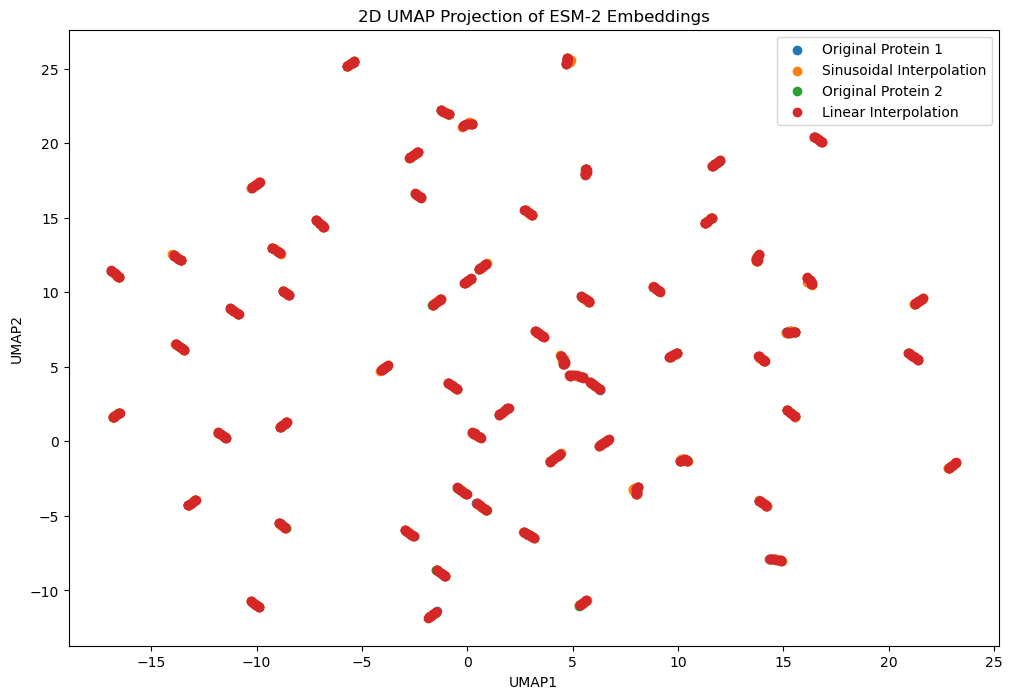

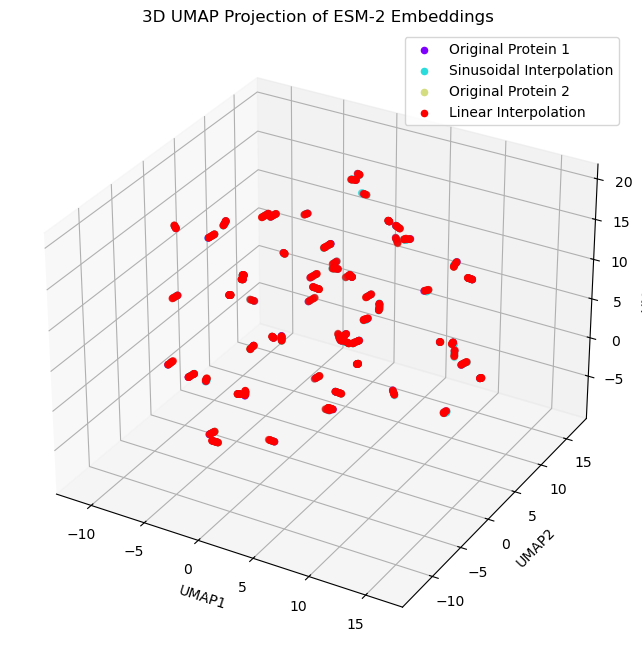

In [14]:
# --- UMAP Visualization ---
# Combine embeddings (originals + linear and sinusoidal interpolations)
all_embeddings = torch.cat(
    [sequence_embedding_1, sequence_embedding_2] + linear_interpolations + sinusoidal_interpolations,
    dim=0
).numpy()

# Create labels for plotting
labels = (
    ["Original Protein 1"] * sequence_embedding_1.shape[0] +
    ["Original Protein 2"] * sequence_embedding_2.shape[0] +
    ["Linear Interpolation"] * (len(lambdas) * sequence_embedding_1.shape[0]) +
    ["Sinusoidal Interpolation"] * (len(lambdas) * sequence_embedding_1.shape[0])
)

# Plot the 2D UMAP projection (function defined in visualization.py)
plot_umap_2d(all_embeddings, labels, title="2D UMAP Projection of ESM-2 Embeddings")

# Plot the 3D UMAP projection
plot_umap_3d(all_embeddings, labels, title="3D UMAP Projection of ESM-2 Embeddings")

In [15]:
# --- Decoder Example using the ESM2EncoderModel ---
# Create a configuration using create_config() from config.py
config = create_config()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
encoder_model = ESM2EncoderModel(config=config, device=device, enc_normalizer=None, decoder_path=None, max_seq_len=256)

# Use the helper function (from interpolations.py) to decode interpolated embeddings
decoded_linear_sequences = decode_interpolations(linear_interpolations, encoder_model)
decoded_sinusoidal_sequences = decode_interpolations(sinusoidal_interpolations, encoder_model)
decoded_arccos_sequences = decode_interpolations(arccos_interpolations, encoder_model)

print("Decoded Linear Interpolated Sequences:")
for seq in decoded_linear_sequences:
    print(seq)

print("\nDecoded Sinusoidal Interpolated Sequences:")
for seq in decoded_sinusoidal_sequences:
    print(seq)

print("\nDecoded Arccos Interpolated Sequences:")
for seq in decoded_arccos_sequences:
    print(seq)

Decoded Linear Interpolated Sequences:
DSECLKEYGGDVGFGFCAPRIYPSFCVQRCRADKGALSGKCIWGQGSNVKCLCNFCRHEP
MSECLKEYGGDVGFGFCAPRIYPSFCVQRCRADKGALSGKCIWGQGSNVKCLCNFCRHEP
MSECLKEYGGDVGFGFCAPRIYPSFCVQRCRADKGALSGKCIWGQGSNVKCLCNFCRHEP
MSECLKEYGGDVGFGFCAPRIYPSFCVQRCRADKGALSGKCISGQGSNVKCLCNFCRHEP
MSECLKENGADKGFGSCAGRILRSFCVQRCRKDKGALSGKCISGAGSNVKCLCNFCRHEP
MIWSSIKNLASKAWNSCIGRSLRNKCAGACRKFVGAKSGKCISQAGSNTKCECVDCRYED
GIWSSIKNLASKAWNSDIGQSLRNKAAGAINKFVADKIGVTPSQAASMTLDEIVDAMYYD
GIWSSIKNLASKAWNSDIGQSLRNKAAGAINKFVADKIGVTPSQAASMTLDEIVDAMYYD
GIWSSIKNLASKAWNSDIGQSLRNKAAGAINKFVADKIGVTPSQAASMTLDEIVDAMYYD
GIWSSIKNLASKAWNSDIGQSLRNKAAGAINKFVADKIGVTPSQAASMTLDEIVDAMYYD

Decoded Sinusoidal Interpolated Sequences:
GIWSSIKNLASKAWNSDIGQSLRNKAAGAINKFVADKIGVTPSQAASMTLDEIVDAMYYD
GIWSSIKNLASKAWNSDIGQSLRNKAAGAINKFVADKIGVTPSQAASMTLDEIVDAMYYD
GIWSSIKNLASKAWNSDIGQSLRNKAAGAINKFVADKIGVTPSQAASMTLDEIVDAMYYD
MIWSSIKNLASKAWNSDIGQSLRNKAAGAINKFVADKIGVTPSQAASMTLDEIVDAMYED
MIWSSIKNLASKAWNSCIGRSLRNKCAGACRKFVGAKSGKCISGAGSNTKCLCVDCRYED
MS

In [ ]:
# --- Random Sequence Experiment ---
# (Compute average Levenshtein distance over random sequences.)
num_sequences = 1000
distance_list = []
for _ in range(num_sequences):
    orig_seq = generate_random_sequence(20, 120)
    # Encode and decode the random sequence using the decoder model
    encoded_seq, _ = encoder_model.batch_encode([orig_seq])
    decoded_seq = encoder_model.batch_decode(encoded_seq)[0]
    distance_list.append(levenshtein_distance(orig_seq, decoded_seq))

print("Average Levenshtein Distance:", np.mean(distance_list)) # this will take a while (≈ 27 minutes)

Average Levenshtein Distance: 0.995


In [ ]:
import pandas as pd

# Make sure to have the correct pathname here.
interpolated_seqs_df = pd.read_csv("/Users/johnmars/Desktop/Msc-Github/PLMs/generated-data/interpolated_sequences.csv")
interpolated_seqs_df

,Lambda,Type,Sequence
0,0.000000,Linear,DSECLKEYGGDVGFGFCAPRIYPSFCVQRCRADKGALSGKCIWGQG...
1,0.111111,Linear,MSECLKEYGGDVGFGFCAPRIYPSFCVQRCRADKGALSGKCIWGQG...
2,0.222222,Linear,MSECLKEYGGDVGFGFCAPRIYPSFCVQRCRADKGALSGKCIWGQG...
3,0.333333,Linear,MSECLKEYGGDVGFGFCAPRIYPSFCVQRCRADKGALSGKCISGQG...
4,0.444444,Linear,MSECLKENGADKGFGSCAGRILRSFCVQRCRKDKGALSGKCISGAG...
5,0.555556,Linear,MIWSSIKNLASKAWNSCIGRSLRNKCAGACRKFVGAKSGKCISQAG...
6,0.666667,Linear,GIWSSIKNLASKAWNSDIGQSLRNKAAGAINKFVADKIGVTPSQAA...
7,0.777778,Linear,GIWSSIKNLASKAWNSDIGQSLRNKAAGAINKFVADKIGVTPSQAA...
8,0.888889,Linear,GIWSSIKNLASKAWNSDIGQSLRNKAAGAINKFVADKIGVTPSQAA...
9,1.000000,Linear,GIWSSIKNLASKAWNSDIGQSLRNKAAGAINKFVADKIGVTPSQAA...
